# Note!

To run this notebook, you first need to train models using the bash script we provide.

Make sure, that the models were trained with centralized IID data (when cn (clients number) is 1).

Then in the cell number 3 enter the Path to a valid model.


In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
import torch
from tqdm.auto import tqdm
from src.config.models import NatPnModel, LeNet5, ResNet18
from data.utils.datasets import DATASETS
from data.utils.constants import MEAN, STD
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import Compose, Normalize
import src.config.nat_pn.distributions as D
from src.config.utils import evaluate, evaluate_only_classifier, validate_accuracy_per_client, evaluate_switch, quantiles
from src.config.nat_pn.loss import BayesianLoss
from src.config.uncertainty_metrics import (
    load_dataset,
    load_dataloaders,
    choose_threshold,
    load_model,
    expected_entropy,
)

from torch.nn import CrossEntropyLoss
from typing import Optional
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import math
from copy import deepcopy
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
dataset_name = 'noisy_mnist'
noisy_classes = [5, 6, 7, 8, 9]

path = # YOUR PATH TO A VALID MODEL IS HERE
# for example 
# path = f"../out/FedAvg/centralized_all_params_stopgrad_logp_{dataset_name}_1_natpn.pt"

backbone = 'lenet5'
stopgrad = True

device = 'cpu'
all_params_dict = torch.load(path, map_location=device)

ALPHA_THRESHOLD = 0.95

In [4]:
data_indices, trainset, testset = load_dataset(dataset_name=dataset_name)

In [5]:
dataset_index = 0
trainloader, testloader, calloader = load_dataloaders(
    client_id=dataset_index, data_indices=data_indices, trainset=trainset, testset=testset, batch_size=1024,
)

In [6]:
criterion = BayesianLoss(entropy_weight=0.0, log_prob_weight=0.01, embeddings_weight=1.0,
                           reduction='sum')

In [7]:
model = load_model(
    dataset_name=dataset_name,
    backbone=backbone,
    stopgrad=stopgrad,
    index='global',
    all_params_dict=all_params_dict,
)
model.to(device)
model.eval()
print('1')

1


In [8]:
true_labels = []
pred_labels = []

aleatoric_uncertainties = []
epistemic_uncertainties_entropy = []
epistemic_uncertainties_log_prob = []

with torch.no_grad():
    for batch in testloader:
        x, y = batch[0].to(device), batch[1].to(device)
        y_pred, log_prob, embeddings = model.train_forward(x, clamp=False)
        
        alpha = y_pred.alpha
        pred = torch.argmax(alpha, -1)
        
        true_labels.append(y.cpu().numpy())
        pred_labels.append(pred.cpu().numpy())
        
        aleatoric_uncertainties.append(expected_entropy(alpha=alpha.cpu().numpy()))
        epistemic_uncertainties_entropy.append(y_pred.entropy().cpu().numpy())
        epistemic_uncertainties_log_prob.append(log_prob.cpu().numpy())

true_labels = np.hstack(true_labels)
pred_labels = np.hstack(pred_labels)

aleatoric_uncertainties = np.hstack(aleatoric_uncertainties)
epistemic_uncertainties_entropy = np.hstack(epistemic_uncertainties_entropy)
epistemic_uncertainties_log_prob = np.hstack(epistemic_uncertainties_log_prob)

In [9]:
noisy_labels_mask = np.isin(true_labels, noisy_classes)

In [10]:
import matplotlib
def pretty_matplotlib_config(fontsize=15):
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rcParams['text.usetex'] = True
    matplotlib.rcParams.update({'font.size': fontsize})
    
pretty_matplotlib_config(40)

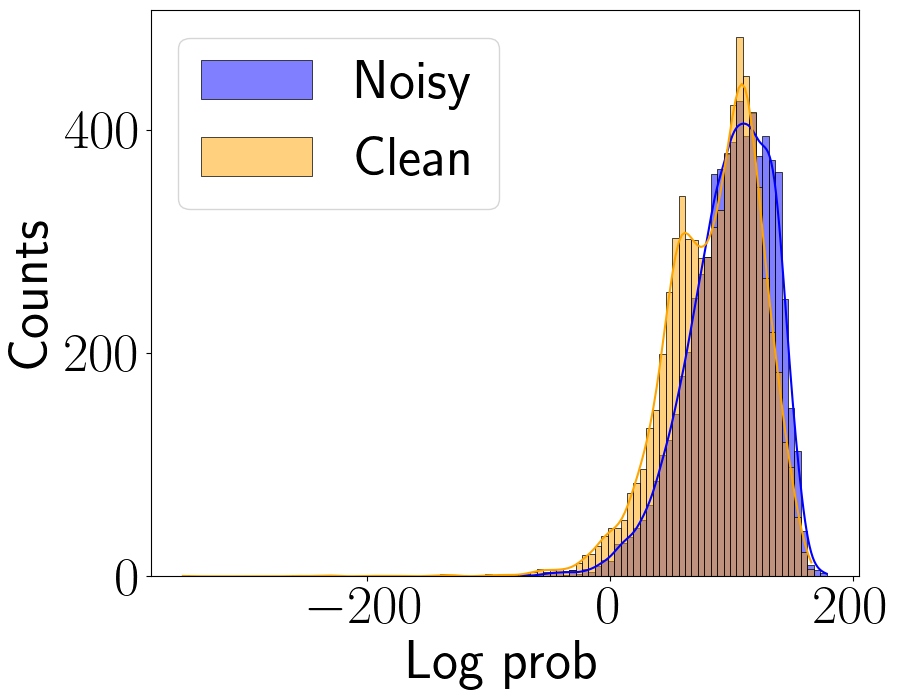

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Let's say these are your arrays
array1 = epistemic_uncertainties_log_prob[noisy_labels_mask]
array2 = epistemic_uncertainties_log_prob[~noisy_labels_mask]

n_bins = 100
bin_edges = np.linspace(min(epistemic_uncertainties_log_prob), max(epistemic_uncertainties_log_prob), num=n_bins+1)

# Define common parameters for the plots
kwargs = {
    'bins': bin_edges, 
    'alpha': 0.5, 
    'kde': True, 
}

# Initialize figure and axes
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)

# Plot the histograms
sns.histplot(array1, color='blue', **kwargs, ax=ax, label='Noisy')
sns.histplot(array2, color='orange', **kwargs, ax=ax, label='Clean')

# Customize the plot
# ax.set_title('Histogram with KDE for Array 1 and Array 2')
ax.set_xlabel('Log prob')
ax.set_ylabel('Counts')
plt.legend()

# Show the plot
plt.tight_layout()
# plt.savefig(f'epistemic_{dataset_name}.pdf', format='pdf')
plt.show()

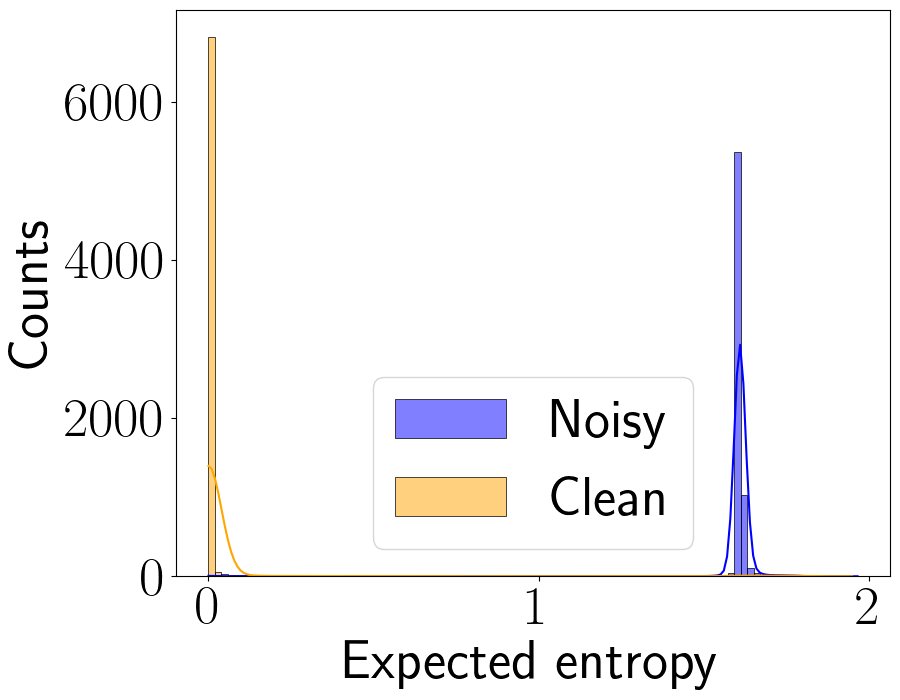

In [12]:
# Let's say these are your arrays
array1 = aleatoric_uncertainties[noisy_labels_mask]
array2 = aleatoric_uncertainties[~noisy_labels_mask]

n_bins = 100
bin_edges = np.linspace(min(aleatoric_uncertainties), max(aleatoric_uncertainties), num=n_bins+1)

# Define common parameters for the plots
kwargs = {
    'bins': bin_edges, 
    'alpha': 0.5, 
    'kde': True, 
}

# Initialize figure and axes
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)

# Plot the histograms
sns.histplot(array1, color='blue', **kwargs, ax=ax, label='Noisy')
sns.histplot(array2, color='orange', **kwargs, ax=ax, label='Clean')

# Customize the plot
# ax.set_title('Histogram with KDE for Array 1 and Array 2')
ax.set_xlabel('Expected entropy')
ax.set_ylabel('Counts')
plt.legend()

# Show the plot
plt.tight_layout()
# plt.savefig(f'aleatoric_{dataset_name}.pdf', format='pdf')
plt.show()